# Problem 15
Estimate K values with modified Wilson correlation and perform flash calculation of 3 component mixture

In [5]:
import math
from tabulate import tabulate
R = 10.73146 # Universal gas constant, psia-ft3/R-lbm mol

In [38]:
# Per Table B-18 and B-19
comps = ['C1', 'C3', 'nC5']
z = [0.20, 0.32, 0.48]
pc = [667.8, 616.3, 488.6]
tc = [343.0, 665.7, 845.4]
w = [0.0115, 0.1454, 0.251]

# As specified by problem scenario
pk = 2000 # Convergence pressure psia 
p = 500 # psia
t = 160 # deg F
A2 = 0.7 # problem characterizes this as A0, but I assume this is a misprint as A0 doesn't factor into these equations

In [39]:
# Setup a function we can call for the modified Wilson correlation
def k_mod_wilson(w, tc, pc, t, p, pk, A2):
    A1 = 1-((p-14.7)/(pk-14.7))**A2 # Eq 3.160 - assuming pressures given in psia, Eq 3.160 is in terms of psig
    tr = t/tc
    pr = p/pc
    return (pc/pk)**(A1-1)*math.exp(5.37*A1*(1+w)*(1-1/tr))/pr # Eq 3.159

In [40]:
# Calculate all the Ki's
ncomps = len(comps)
K = [k_mod_wilson(w[i], tc[i], pc[i], t+460, p, pk, A2) for i in range(ncomps)]

# And print out summary
print('Table B-19 Component Properties (Problem 15)\n')
header=['Component', 'pci', 'tci', 'wi', 'Ki']
table = []
for i in range(ncomps):
    table.append([comps[i], pc[i], tc[i], w[i], round(K[i],3)])
print(tabulate(table,headers=header))

Table B-19 Component Properties (Problem 15)

Component      pci    tci      wi     Ki
-----------  -----  -----  ------  -----
C1           667.8  343    0.0115  9.208
C3           616.3  665.7  0.1454  1.439
nC5          488.6  845.4  0.251   0.358


In [41]:
# Muscat-McDowell two-phase split
def MM(Fv, *args):
    z, K = args
    return sum(z[i]/(Fv+(1/(K[i]-1))) for i in range(len(z))) # Eq 4.39

In [42]:
from scipy.optimize import brentq
# Calculate vapor fraction to solve the Muscat-McDowell equation
data = (z, K)
Fv = brentq(MM,0,1, args = data) # Use SciPy Python solver brentq instead of Newton iterations (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brentq.html)

# And print result
print("Vapor fraction associated with first guess Ki's:", round(Fv,5))

Vapor fraction associated with first guess Ki's: 0.48242


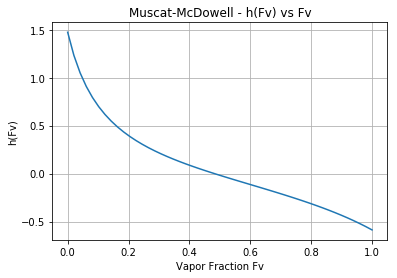

In [43]:
# Just for laughs, plot the associated h(Fv) plot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Fv_plot = np.linspace(0,1)
plt.plot(Fv_plot,[MM(Fv_plot, *data) for Fv_plot in Fv_plot])
plt.xlabel('Vapor Fraction Fv')
plt.ylabel('h(Fv)')
plt.title("Muscat-McDowell - h(Fv) vs Fv")
plt.grid();

In [44]:
# And print out summary
c = [1/(K[i]-1) for i in range(ncomps)]
x = [z[i]/(Fv*(K[i]-1)+1) for i in range(ncomps)] # Eq 4.41
y = [K[i]*x[i] for i in range(ncomps)]
print('Table B-21 Final Flash Calculation Results (Problem 15)\n')
header=['Component', 'zi', 'Ki', 'ci', 'zi/(Fv+ci)', 'zi/(Fv+ci)**2', 'xi', 'yi']
table = []
for i in range(ncomps):
    table.append([comps[i], z[i], round(K[i],4), round(c[i],4), z[i]/(Fv+c[i]), z[i]/(Fv+c[i])**2, x[i], y[i] ])
table.append(['Total', sum(z), ' ', ' ', sum(z[i]/(Fv+c[i]) for i in range(ncomps)), sum(z[i]/(Fv+c[i])**2  for i in range(ncomps)), sum(x), sum(y) ])
print(tabulate(table,headers=header))

Table B-21 Final Flash Calculation Results (Problem 15)

Component      zi  Ki      ci         zi/(Fv+ci)    zi/(Fv+ci)**2         xi        yi
-----------  ----  ------  -------  ------------  ---------------  ---------  --------
C1           0.2   9.2082  0.1218     0.330988          0.547766   0.0403243  0.371313
C3           0.32  1.439   2.2777     0.115936          0.0420036  0.26407    0.380006
nC5          0.48  0.3575  -1.5564   -0.446924          0.416128   0.695606   0.248681
Total        1                       -7.4496e-14        1.0059     1          1
